# Kaggle: Telco Customer Churn Dataset using TensorFlow Estimators

Task: Given the provided dataset, build and evaluate a model for a telco that predicts churn.

* Source: https://www.kaggle.com/blastchar/telco-customer-churn

* Tutorial: https://www.tensorflow.org/tutorials/estimator/premade

In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf
from matplotlib import pyplot as plt
import seaborn as sns
sns_colors = sns.color_palette('colorblind')

from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import roc_curve

from IPython.display import clear_output

In [2]:
# Load dataset.
csv_file = 'Telco-Customer-Churn.csv'
df = pd.read_csv(csv_file)

# Step 1: Data cleaning

## 1.1 Data overview

In [3]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
# Number of rows and columns
df.shape

(7043, 21)

## 1.2 Duplicate data
In this dataset, it is reasonable to expect that two customers could have the same feature set. Therefore, duplicate data in this case would only be repeated customer ids. Since there are the same number of unique ids as rows, there are no duplicates. 

In [5]:
len(df['customerID'].unique())

7043

## 1.3 Missing values
TotalCharges contains some missing values. These are found and replaced with a null value using a regex function. 

In [6]:
df['TotalCharges'].replace(r'^\s*$', np.nan, regex=True).isnull().sum()

11

Normally, you would fill the empty values with the feature median value. However, in this dataset each null value corresponds to a tenure of zero. The data in TotalCharges is not missing but erroneously recorded. 

In [7]:
df[df['TotalCharges'].isnull() == True]['tenure']

Series([], Name: tenure, dtype: int64)

In [8]:
# The empty spaces are be filled with 0.0.  
df['TotalCharges'] = df['TotalCharges'].replace(r'^\s*$', np.nan, regex=True).fillna(0.0)
# Correct the column datatype
df['TotalCharges'] = df['TotalCharges'].astype('float64')

# Step 2: Data Exploration
Plotting the raw features against the traget features (churn) to get a first impression of the dataset. 
## 2.1 Customer demographics

In [9]:
# Function to generate subplots from categorial feature list
def plot_features_bar(flist,target):
    # Define space around sublots
    plt.subplots_adjust(wspace = 0.5)
    plt.subplots_adjust(hspace = 0.5)
    
    i = 0
    for ax in axes.flatten():
        # Group by feature column and target for each subplot
        data = df.groupby([flist[i],target]).size().to_frame('occurences').reset_index()
        sns.barplot(x=flist[i], y='occurences', hue=target, data=data, ax=ax)
        i = i+1
        
def plot_features_line(flist,target):
    # Define space around sublots
    plt.subplots_adjust(wspace = 0.5)
    plt.subplots_adjust(hspace = 0.5)
    
    i = 0
    for ax in axes.flatten():
        # Group by feature column and target for each subplot
        data = df.groupby([flist[i],target]).size().to_frame('occurences').reset_index()
        sns.lineplot(x=flist[i], y='occurences', hue=target, data=data, ax=ax)
        i = i+1

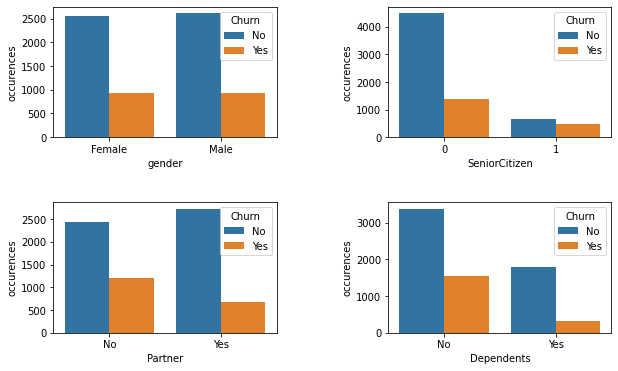

In [10]:
target = 'Churn'
demographics = ['gender','SeniorCitizen', 'Partner','Dependents']

f, axes = plt.subplots(2, 2, figsize=(10,6))       
plot_features_bar(demographics,target)

### Insights
1. There are an equal number of males and females, and they have an equal chance of churning. This is clearly not a predictive feature for the model. 
2. A customer is more less to churn if they have a partner, and less likely again if they have dependents. Families have lower chance of churning than the general public.

## 2.2 Customer services

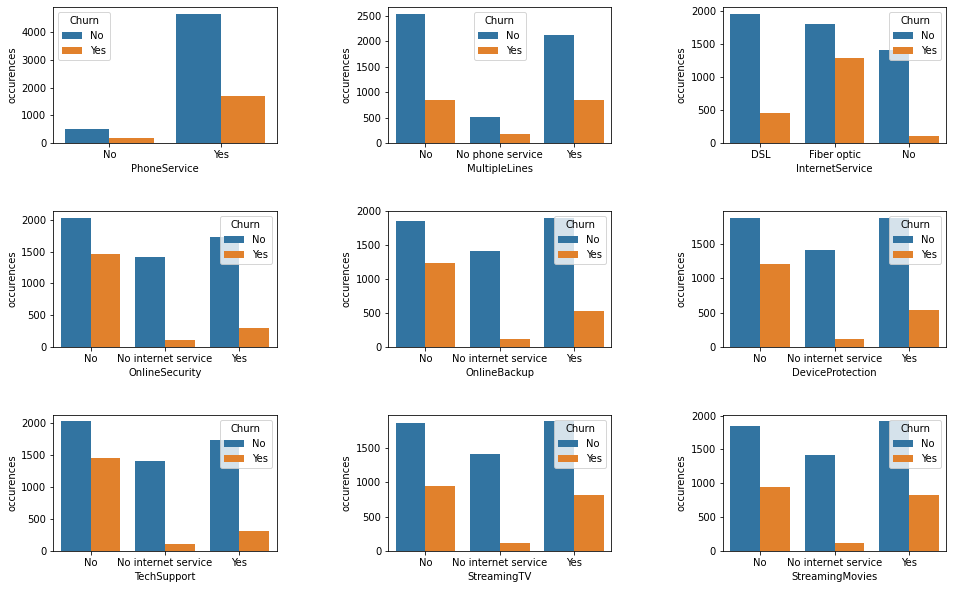

In [11]:
services = ['PhoneService', 'MultipleLines', 'InternetService',
            'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
            'TechSupport', 'StreamingTV', 'StreamingMovies']

f, axes = plt.subplots(3, 3, figsize=(16,10))    
plot_features_bar(services,target)

### Insights
1. The churn rate for customers with the Fiber optic Internet Service option is far higher than that of the DSL and No Internet Service customers. 
2. The subscribtion services with the highest rate of customer churn are StreamingTV and StreamingMovies. OnlineSecurity and TechSupport subscribed users have a low instance of churn.

=> These services with high churn may be suffering from customer dissatisfaction. 

## 2.3 Customer accounts

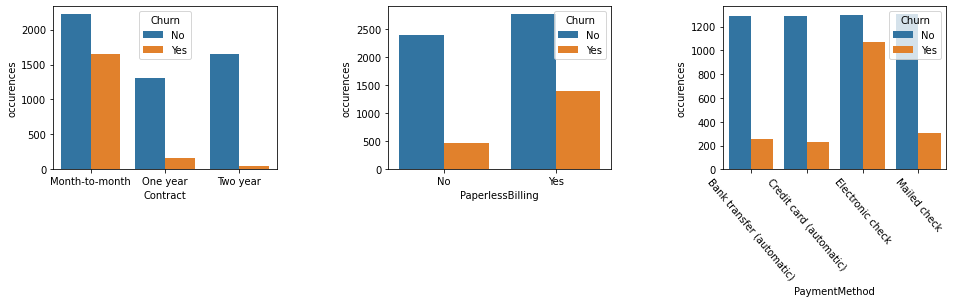

In [12]:
accounts = ['Contract', 'PaperlessBilling','PaymentMethod']

f, axes = plt.subplots(1, 3, figsize=(16,3))  
#rotating the labels for the last subplot
plt.tick_params(axis='x',labelrotation=310)
plot_features_bar(accounts,target)

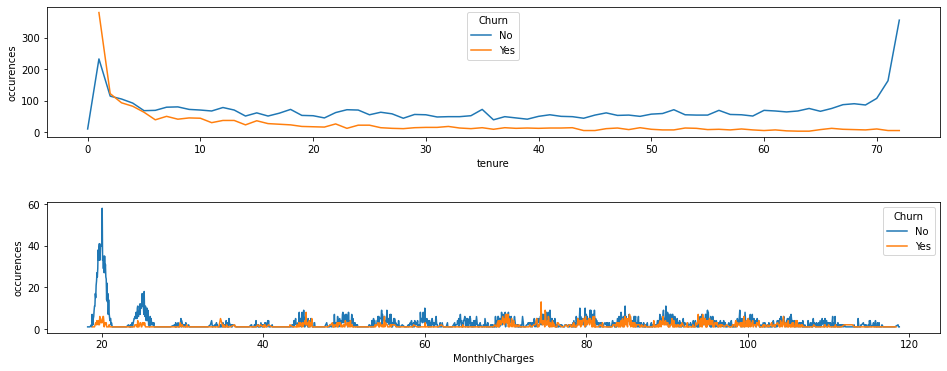

In [13]:
f, axes = plt.subplots(2, 1, figsize=(16,6))
#axes.axis(xmin=0,xmax=2000)
accounts_cont = ['tenure','MonthlyCharges']
plot_features_line(accounts_cont,target)

## Insights
1. Most customers are on a month-to-month contract. Customers on this contract are far more likely to churn than those on the one/two year contracts. This should be a stong predictor of churn.
2. Customers who use PaperlessBilling and pay for their subscriptions using Electronic checks have higher instances of churn. This could be an indication that more tech savvy customers are more likely to churn.
3. The longer an individual has been a customer the less likely they are to churn. 
4. Customers with very low monthly charges have fewer instances of churn.

=> Promoting customers to purchase one/two year contracts would reduce the churn prediction, but this may not address any underlying service issues that could be driving churn.

=> Churn prevention measures could be focused on new customers.

# Step 3: Data preparation

## 3.1 Normalisation
The columns tenure, MonthlyCharges, and TotalCharges are continuous numeric features and should be normalised in order to lessen the impact of outlier data points on the model. Z-Score normalisation is the typical method used.

In [14]:
norm_features = ['tenure','MonthlyCharges','TotalCharges']
df[norm_features].describe()

,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000
mean,32.371149,64.761692,2279.734304
std,24.559481,30.090047,2266.794470
min,0.000000,18.250000,0.000000
25%,9.000000,35.500000,398.550000
50%,29.000000,70.350000,1394.550000
75%,55.000000,89.850000,3786.600000
max,72.000000,118.750000,8684.800000


The general method of calculation is to determine the distribution mean and standard deviation for each feature. Next we subtract the mean from each feature. Then we divide the values (mean is already subtracted) of each feature by its standard deviation. 

In [15]:
for feature in norm_features:
    df[feature] = (df[feature] - df[feature].mean()) / df[feature].std()
    
df[norm_features]

,tenure,MonthlyCharges,TotalCharges
0,-1.277354,-1.160241,-0.992540
1,0.066323,-0.259611,-0.172152
2,-1.236636,-0.362635,-0.957998
3,0.514215,-0.746482,-0.193659
4,-1.236636,0.197351,-0.938808
...,...,...,...
7038,-0.340852,0.665945,-0.127596
7039,1.613587,1.277443,2.242447
7040,-0.870179,-1.168549,-0.852871
7041,-1.155201,0.320315,-0.870451


## 3.2 Redundant data & Datatype conversions
A number of features in the dataset contain, what appear to me to be, redundant categories. There appears to be little difference between the category labels 'No' and 'No phone/internet service', the additional information can be derived, and therefore should be combined. This will reduce the complexity of the feature. Furthermore, because there are fewer instances of 'No phone/internet service' the feature harder to learn by the model accurately.

# Step 2: Data preparation

In [16]:
df['MultipleLines'].value_counts()

No                  3390
Yes                 2971
No phone service     682
Name: MultipleLines, dtype: int64

In [17]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,-1.277354,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,-1.160241,-0.992540,No
1,5575-GNVDE,Male,0,No,No,0.066323,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,-0.259611,-0.172152,No
2,3668-QPYBK,Male,0,No,No,-1.236636,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,-0.362635,-0.957998,Yes
3,7795-CFOCW,Male,0,No,No,0.514215,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),-0.746482,-0.193659,No
4,9237-HQITU,Female,0,No,No,-1.236636,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,0.197351,-0.938808,Yes


Additionally, all the features, including the target feature 'Churn', with Yes/No columns labels are converted to 1/0.

In [18]:
tf_features = ['Partner', 'Dependents', 'PhoneService', 'MultipleLines','OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
           'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 'Churn']

for col in tf_features:
    df[col] = np.where(df[col] == 'Yes', 1, 0)

In [19]:
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner               int64
Dependents            int64
tenure              float64
PhoneService          int64
MultipleLines         int64
InternetService      object
OnlineSecurity        int64
OnlineBackup          int64
DeviceProtection      int64
TechSupport           int64
StreamingTV           int64
StreamingMovies       int64
Contract             object
PaperlessBilling      int64
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                 int64
dtype: object

Removing the unnecessary customerID column.

In [20]:
df = df.drop(['customerID'], axis=1)

## 3.3 Data resampling
In order to determine the accuracy of any prediction model, there should be an equal number of samples belonging each category in the target feature. 

In [21]:
df['Churn'].value_counts()

0    5174
1    1869
Name: Churn, dtype: int64

Upsampling is implemented to balance the majority class. Data loss is a greater concern than efficiency using this small dataset. There is a risk that outlier data points could be unintentionally enhanced using this sampling method, however the previous normalisation step should curtail this effect.

In [22]:
df_majority = df[df['Churn']==0]
df_minority = df[df['Churn']==1]

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority),    # to match majority class
                                 random_state=42) # reproducible results

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

# Display new class counts
df_upsampled['Churn'].value_counts()

1    5174
0    5174
Name: Churn, dtype: int64

In [23]:
df_upsampled.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,1,0,-1.277354,0,0,DSL,0,1,0,0,0,0,Month-to-month,1,Electronic check,-1.160241,-0.992540,0
1,Male,0,0,0,0.066323,1,0,DSL,1,0,1,0,0,0,One year,0,Mailed check,-0.259611,-0.172152,0
3,Male,0,0,0,0.514215,0,0,DSL,1,0,1,1,0,0,One year,0,Bank transfer (automatic),-0.746482,-0.193659,0
6,Male,0,0,1,-0.422287,1,1,Fiber optic,0,1,0,0,1,0,Month-to-month,1,Credit card (automatic),0.808849,-0.145728,0
7,Female,0,0,0,-0.910897,0,0,DSL,1,0,0,0,0,0,Month-to-month,0,Mailed check,-1.163564,-0.872525,0


## 3.4 Splitting into training, validation, and test datasets
The training data is used by the mdodel to learning the patterns in the dataset. The validation set is used during the model development cycle to help evaluate the fitness of each model iteration. The additional test split is used at the very end to insure that the model has not been overfit.

A ratio of 70:15:15 is recommended in this article: https://glassboxmedicine.com/2019/09/15/best-use-of-train-val-test-splits-with-tips-for-medical-data/

In [24]:
dftrain, dftest = train_test_split(df_upsampled, test_size=0.15)
dftrain, dfeval = train_test_split(dftrain, test_size=0.18)

print('{:.0f} % train examples'.format(len(dftrain)/len(df_upsampled)*100))
print('{:.0f} % validation examples'.format(len(dfeval)/len(df_upsampled)*100))
print('{:.0f} % final test examples'.format(len(dftest)/len(df_upsampled)*100))

y_train = dftrain.pop('Churn')
y_eval = dfeval.pop('Churn')
y_test = dftest.pop('Churn')

70 % train examples
15 % validation examples
15 % final test examples


# Step 4: Build the model
#### Model selection
This dataset represents a binary classification problem with multiple categorial and numerical features.
A linear regression model will first be constructed to provide a baseline model. In addition, the BoostedTrees model from the TensorFlow api is a good candidate to capture the relationships between the features in the dataset.

## 4.1 Define the input functions 

### Variable selection
The tensorflow tutorial default values for num_epochs and batch_size are 10 and 32 respectively. These varaibles require tuning for each individual dataset. Larger batchs reduce variablity, small batches are more efficient. 

* After some minor tuning these varaibles are set to: num_epochs = 100, batch_size = 64. They yeild higher accuracy in the linear regression model, while also trying minimizing loss. 

In [25]:
def make_input_fn(data_df, label_df, num_epochs=100, shuffle=True, batch_size=64):
  def input_function():
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
    if shuffle:
      ds = ds.shuffle(1000)
    ds = ds.batch(batch_size).repeat(num_epochs)
    return ds
  return input_function

train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)
test_input_fn = make_input_fn(dftest, y_test, num_epochs=1, shuffle=False)

In [26]:
# Feature column function
# Data conversion for compatibility with tensorflow estimator functions
def make_feature_columns(CATEGORICAL_COLUMNS,NUMERIC_COLUMNS):
    feature_columns = []
    
    for feature_name in CATEGORICAL_COLUMNS:
      vocabulary = dftrain[feature_name].unique()
      feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))
    
    for feature_name in NUMERIC_COLUMNS:
      feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float64))
    
    return feature_columns    

In [27]:
# Defining feature columns
CATEGORICAL_COLUMNS = [ 'gender','InternetService','Contract', 'PaymentMethod', 'SeniorCitizen', 'Partner', 
                        'Dependents', 'PhoneService', 'MultipleLines','OnlineBackup', 'DeviceProtection',
                        'TechSupport', 'StreamingTV', 'StreamingMovies','PaperlessBilling']

NUMERIC_COLUMNS = ['tenure','MonthlyCharges', 'TotalCharges']

feature_columns = make_feature_columns(CATEGORICAL_COLUMNS,NUMERIC_COLUMNS)

## 4.2 Build the linear regression model

In [28]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)
linear_est.train(train_input_fn)
result = linear_est.evaluate(eval_input_fn)

clear_output()
print(pd.Series(result))

accuracy                    0.777146
accuracy_baseline           0.502525
auc                         0.854128
auc_precision_recall        0.837186
average_loss                0.476068
label/mean                  0.497475
loss                        0.476840
precision                   0.752028
prediction/mean             0.500317
recall                      0.823604
global_step             11300.000000
dtype: float64


## 4.3 Evaluation: linear regression model 
This model performs quite well. It has an accuracy of 77%, a good false postive to true postive ratio of 85%, while also maintaining a low value for loss (0.49).

This is an improvment from the previous notebook, the upsampling process has had a positive effect.

<AxesSubplot:title={'center':'predicted probabilities'}, ylabel='Frequency'>

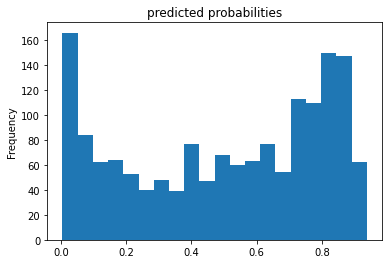

In [29]:
pred_dicts = list(linear_est.predict(eval_input_fn))
clear_output()

probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist', bins=20, title='predicted probabilities')

## 4.4 Build the Boosted Trees model

### Variable selection
The tensorflow tutorial default values for n_trees and max_depth are 2 and 6 respectively. These varaibles also require tuning.

The tutorial suggest setting n_batches_per_layer to 1 for small datasets. 'Since data fits into memory, use entire dataset per layer. It will be faster.' However, when the model was run with this value some in very high values for loss were observed. n_batches_per_layer=10 and n_batches_per_layer=20 had similar results.

The suggested vaule for max_depth is between 4 and 8. Varying this parameter didn't result in significant difference between the trained models, so the default max_depth=6 was used.

The 'Understanding BoostedTrees' tutorial uses n_trees=50. 50 feels like a sifficiently large sample size.

In [30]:
params = {
  'n_trees': 50,
  'max_depth': 6,
  'n_batches_per_layer': 10,
  'center_bias': True
}

tree_est = tf.estimator.BoostedTreesClassifier(feature_columns=feature_columns,**params)
tree_est.train(train_input_fn)
result = tree_est.evaluate(eval_input_fn)

clear_output()
print(pd.Series(result))

accuracy                   0.791667
accuracy_baseline          0.502525
auc                        0.862507
auc_precision_recall       0.826261
average_loss               0.467418
label/mean                 0.497475
loss                       0.467428
precision                  0.767523
prediction/mean            0.502271
recall                     0.833756
global_step             3640.000000
dtype: float64


## 4.5 Evaluation: boosted trees model

This model performs better than the linear regression model. It has a higher accuracy of 79%, a higher false postive to true postive ratio of 86%, while also maintaining a lower value for loss (0.46).

This is another improvement over the previous notebook that again I assume is due to the upsampling. In the first attempt, the linear regression model outpreformed the boostedtrees model (without feature selection).

# 5: Feature selection
In order to improve the models overall accuracy, and to shield it from overfitting, unimportant and highly correlated features can be removed from the dataset.

## 5.1 Cirteria: Correlation
"Remove one of two features that have a correlation higher than 0.9".

Source: https://towardsdatascience.com/feature-selection-correlation-and-p-value-da8921bfb3cf

* TotalCharges and tenure are the only features that are highly correlated. During the exploration step, tenure was shown to be a predictive feature, so TotalCharges is a candidate for elimination. 

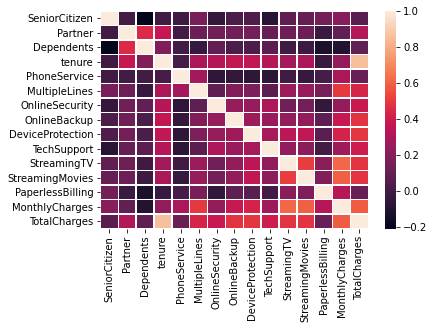

In [32]:
heatmap = dftrain.corr()
ax = sns.heatmap(heatmap, linewidth=0.5)
plt.show()

## 5.2 Cirteria: Permutation feature importance

In [33]:
def permutation_importances(est, X_eval, y_eval, metric, features):
    """Column by column, shuffle values and observe effect on eval set.

    source: http://explained.ai/rf-importance/index.html
    A similar approach can be done during training. See "Drop-column importance"
    in the above article."""
    baseline = metric(est, X_eval, y_eval)
    imp = []
    for col in features:
        save = X_eval[col].copy()
        X_eval[col] = np.random.permutation(X_eval[col])
        m = metric(est, X_eval, y_eval)
        X_eval[col] = save
        imp.append(baseline - m)
    return np.array(imp)

def accuracy_metric(est, X, y):
    """TensorFlow estimator accuracy."""
    return est.evaluate(input_fn=eval_input_fn)['accuracy']

In [34]:
features = CATEGORICAL_COLUMNS + NUMERIC_COLUMNS 
importances = permutation_importances(tree_est, dfeval, y_eval, accuracy_metric, features)
df_imp = pd.Series(importances, index=features)
clear_output()

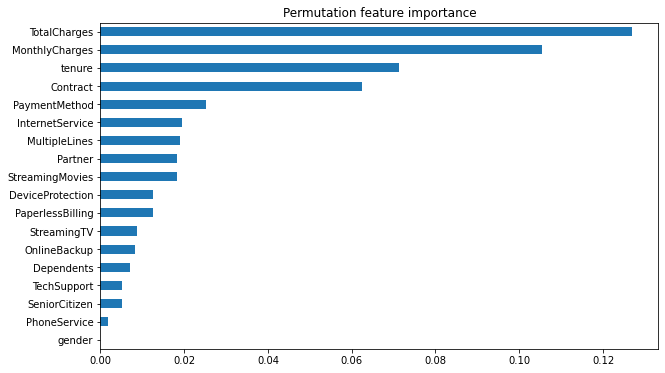

In [35]:
sorted_ix = df_imp.abs().sort_values().index
ax = df_imp[sorted_ix][-20:].plot(kind='barh', figsize=(10, 6))
ax.grid(False, axis='y')
ax.set_title('Permutation feature importance')
plt.show()


### Adding a random variable to the dataset and rebuilding
"Additionally, remove features the are less important than a random variable". Source: https://explained.ai/rf-importance/index.html

In [36]:
rand_df = df.copy()
rand_df['random'] = np.random.uniform(low=0.0, high=1.0, size=(df.shape[0]))

# Splitting the dataset into training and evaluation data
rand_dftrain, rand_dfeval = train_test_split(rand_df, test_size=0.2)
rand_y_train = rand_dftrain.pop('Churn')
rand_y_eval = rand_dfeval.pop('Churn')

train_input_fn = make_input_fn(rand_dftrain, rand_y_train)
eval_input_fn = make_input_fn(rand_dfeval, rand_y_eval, num_epochs=1, shuffle=False)

### Iteritively remove unimportant features
* Rerun this cell with updated feature lists

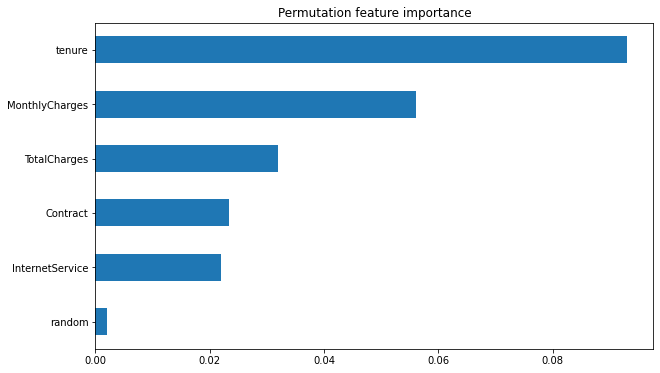

In [37]:
# Defining feature columns
CATEGORICAL_R = ['InternetService', 'Contract']

NUMERIC_R = ['tenure', 'MonthlyCharges', 'TotalCharges', 'random']

removed = ['PhoneService', # Round 1
           'TechSupport', 'PaperlessBilling','StreamingMovies','Partner', #Round 2
           'gender','DeviceProtection', 'StreamingTV', 'SeniorCitizen',   #Round 2
           'PaymentMethod', 'MultipleLines', 'OnlineBackup', 'Dependents', #Round 3
          ]

feature_columns = make_feature_columns(CATEGORICAL_R,NUMERIC_R)
features = CATEGORICAL_R + NUMERIC_R 
# Build the model
rand_est = tf.estimator.BoostedTreesClassifier(feature_columns, **params)

# Train model.
rand_est.train(train_input_fn)

# Calculate the importances
importances = permutation_importances(rand_est, rand_dfeval, rand_y_eval, accuracy_metric, features)
df_imp = pd.Series(importances, index=features)

clear_output()

# Build the graph
sorted_ix = df_imp.abs().sort_values().index
ax = df_imp[sorted_ix][-20:].plot(kind='barh', figsize=(10, 6))
ax.grid(False, axis='y')
ax.set_title('Permutation feature importance')
plt.show()

### Insight
* Out of 19 features in the dataset only tenure, TotalCharges, MonthlyCharges, InternetService, Contract, and are more significant than a random variable to the model's prediction of churn.
* Tenure and TotalCharges are highly correlated.

# Step 6: Rebuild model using new feature set
InternetService, Contract, tenure, MonthlyCharges

In [38]:
# define input functions
train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)

# define feature columns
CATEGORICAL_COLUMNS = ['InternetService', 'Contract']
NUMERIC_COLUMNS = ['tenure', 'MonthlyCharges']
feature_columns = make_feature_columns(CATEGORICAL_COLUMNS,NUMERIC_COLUMNS)

## 6.1 Linear regression model with feature selection

In [39]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)
linear_est.train(train_input_fn)
result = linear_est.evaluate(eval_input_fn)

clear_output()
print(pd.Series(result))

accuracy                    0.756313
accuracy_baseline           0.502525
auc                         0.837498
auc_precision_recall        0.812868
average_loss                0.495251
label/mean                  0.497475
loss                        0.495812
precision                   0.730505
prediction/mean             0.496968
recall                      0.808376
global_step             11300.000000
dtype: float64


This model has an accuracy of 75%, a good false postive to true postive ratio of 83%, and a low value for loss (0.49). This represents a slight reduction in the accuracy of the linear regression model.

## 6.2 Boosted trees model with feature selection

In [40]:
tree_est = tf.estimator.BoostedTreesClassifier(feature_columns=feature_columns,**params)
tree_est.train(train_input_fn)
result = tree_est.evaluate(eval_input_fn)

clear_output()
print(pd.Series(result))

accuracy                   0.772096
accuracy_baseline          0.502525
auc                        0.852290
auc_precision_recall       0.815514
average_loss               0.464481
label/mean                 0.497475
loss                       0.464403
precision                  0.741243
prediction/mean            0.504538
recall                     0.832487
global_step             3100.000000
dtype: float64


This model has an accuracy of 77%, a false postive to true postive ratio of 85%, and a loss value of 0.46. This also represents a slight reduction in the accuracy of the boosted tree model.

## 6.3 Outcome of feature selection
Neither the linear regression nor boosted tree models improved significantly as a result of the feature selection. In fact, the regression model's accuracy reduced slightly. The parameter tuning had a bigger impact on the model's accuracy than the feature selection.

However, this slight reduction in accuracy may coinsign with a generalised model.

# Step 7: Make Predictions
Finally, test the model's predictive power using the unseen portion of the dataset. This data wasn't involved in the recrusive training process, and so should be a fairly accurate representaion of real world data. This will also determine if the model has only memorised the training and evaluation data resulting in overfitting. 

In [41]:
result = tree_est.evaluate(test_input_fn)

clear_output()
print(pd.Series(result))

accuracy                   0.764327
accuracy_baseline          0.510625
auc                        0.854279
auc_precision_recall       0.826377
average_loss               0.465045
label/mean                 0.489375
loss                       0.455441
precision                  0.733412
prediction/mean            0.497642
recall                     0.814474
global_step             3100.000000
dtype: float64


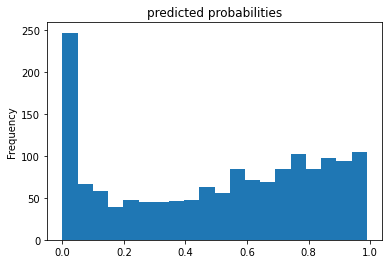

In [42]:
pred_dicts = list(tree_est.predict(test_input_fn))
clear_output()

probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist', bins=20, title='predicted probabilities')
plt.show()

# Conclusion

Built a boosted tree classifer model to predict customer churn with a 76% accuracy rate on unseen data.

## Insights:
* Customer tenure is the most significant contributor to customer churn. High tenure can overcome the impact of other features that would cause a customer to churn.

* Customers with high charges are less likely to churn. Higher monthly charges may correlate with more service subscriptions, leading to sticker customers. 

* A Month-to-Month contract is a stong predictor of customer churn. It is evident that customers are unlikely to break their long term contracts. 

* Customers in the Fiber Optic InternetService option are likely to churn. This may indicate a problem with this service and may require escalation.

* Surprisingly, customer demographics have no impact on their churn prediction. 

* Marketing efforts to prevent churn should be focused on promoting long term contracts and in retaining low tenured customers.


## Potential improvements
* Combine unimportant service features to calculate the number of subscriptions per customer. This may become a predictive variable. 
* Execute a more through investigation of the model parameters to tune the decision tree for higher accuracy.